In [1]:
import numpy as np
import pickle

import skimage.io as skio
import skimage.transform as skit
import skimage.measure as skim
import scipy.optimize as scpo

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
new_style = {'grid': False}
plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-03-31 23:48:17,975 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
class InterpSim(p2p.Simulation):
    def __init__(self, implant, name=None, engine='joblib', dojit=True, num_jobs=-1):
        if not isinstance(implant, p2p.implants.ElectrodeArray):
            e_s = "`implant` must be of type p2p.implants.ElectrodeArray"
            raise TypeError(e_s)

        self.name = name
        self.implant = implant
        self.engine = engine
        self.dojit = dojit
        self.num_jobs = num_jobs

        # Optic fiber layer (OFL): After calling `set_optic_fiber_layer`, this
        # variable will contain a `p2p.retina.Grid` object.
        self.ofl = None

        # Ganglion cell layer (GCL): After calling `set_ganglion_cell_layer`,
        # this variable will contain a `p2p.retina.TemporalModel` object.
        self.gcl = None
        
    def set_ganglion_cell_layer(self, loadfile):
        from scipy.interpolate import RegularGridInterpolator
        import pickle
        
        in_list, out_list = pickle.load(open(loadfile, 'rb'))
        in_arr = np.array(in_list)
        amps = np.unique(in_arr[:, 0])
        freqs = np.unique(in_arr[:, 1])
        ecs = np.unique(in_arr[:, 2])
        out_arr = np.array(out_list).reshape((len(amps), len(freqs), len(ecs)))

        self.gcl = RegularGridInterpolator((amps, freqs, ecs), out_arr,
                                           bounds_error=False, fill_value=None)
        
    def pulse2percept(self, amps, freq, layers=['OFL', 'GCL']):
        if 'OFL' in layers:
            ecs, _ = self.ofl.electrode_ecs(self.implant)
        else:
            _, ecs = self.ofl.electrode_ecs(self.implant)
            
        # Sum up current contributions from all electrodes
        ecs = np.sum(ecs[:, :, 1, :] * amps.flatten(), axis=-1)
        
        out_list = np.array([self.gcl([a, freq, 1]) for a in ecs.flatten()])
        out_list[ecs.flatten() < 0] = 0.0
        return out_list.reshape(ecs.shape)

In [116]:
def calc_ssim(target, pred):
    return skim.compare_ssim(target / target.max(),
                             pred / pred.max(),
                             data_range=1.0,
                             gaussian_weights=True, sigma=1.5,
                             use_sample_covariance=False)

In [163]:
def calc_error(target, pred, amps, mode='ssim', lmb=0.0001):
    # reconstruction error
    if mode.lower() == 'ssim':
        reconst = (1.0 - calc_ssim(target, pred)) / 2.0
    elif mode.lower() == 'rmse':
        reconst = skim.compare_nrmse(target / target.max(), pred / pred.max())
    else:
        raise NotImplementedError

    # regularization
    regular = np.linalg.norm(amps.flatten())
    
    return reconst + lmb * regular

In [ ]:
def step_model(amps, target, sim, layers, lmb=0.0001):
    pred = sim.pulse2percept(amps, 20, layers=layers)
    err = calc_error(target, pred / pred.max(), amps, lmb)
    if np.random.rand() < 0.1:
        print(err)
    return err

In [144]:
def plot_results(img_in, img_out, img_target, lmb=0.0001):
    ssim = calc_ssim(img_target, img_out)
    err = calc_error(img_target, img_out, img_in, mode='rmse', lmb=lmb)
    plt.subplot(131)
    plt.imshow(img_in.reshape((6, 10)), cmap='gray')
    plt.title('in')
    plt.subplot(132)
    plt.imshow(img_out, cmap='gray')
    plt.title('ssim=%.3f err=%.3f' % (ssim, err))
    plt.subplot(133)
    plt.imshow(img_target, cmap='gray')
    plt.title('target')

In [ ]:
letterfile = 'letters/G.jpg'
layers = ['GCL']
picklefile = 'xopt-G-GCL.dat'

In [3]:
implant = p2p.implants.ArgusII()

In [4]:
# The approximated model, interpolated from an input-output function
sim = InterpSim(implant)i
sim.set_optic_fiber_layer(sampling=200)
sim.set_ganglion_cell_layer('temporal-model-amps-freqs-ecs.dat')
sim.gcl.grid

(array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5]))

In [5]:
img = 255 - skio.imread(letterfile)
img.shape, img.min(), img.max()

((200, 256), 0, 255)

In [6]:
img = img[50:150, 70:190]
img_small = skit.resize(img, (6, 10))
img_small.shape, img_small.min(), img_small.max()

((6, 10), 0.0, 1.0)

In [7]:
target = skit.resize(img, sim.ofl.gridx.shape)
target.shape, target.min(), target.max()

((21, 31), 0.0, 1.0)

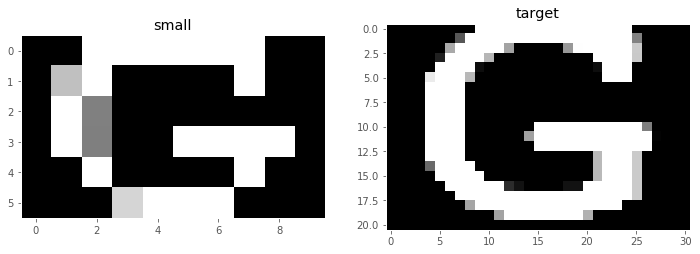

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img_small, cmap='gray')
plt.title('small')
plt.subplot(122)
plt.imshow(target, cmap='gray')
plt.title('target')

In [11]:
assert calc_error(target, target, np.zeros(10), 0.1) == 0.0
assert np.isclose(calc_error(target, target, np.ones(2), 0.25), 0.25 * np.sqrt(2))

In [12]:
xopt = scpo.fmin(step_model, img_small, args=(target, sim, layers, 0.01),
                 maxfun=500 * img_small.size)

0.914559601732
0.914529201498
0.914530068119
0.914526312134
0.914531966273
0.913747254624
0.913985705127
0.913909477879
0.913867764865
0.913724254937
0.913485258505
0.913174461258
0.913102990344
0.912893368677
0.912740351855
0.91232996003
0.91215574159
0.912034450647
0.911891453486
0.911710364647
0.911541986571
0.910613827742
0.910994922946
0.91099108843
0.91007180115
0.910017091839
0.909778279225
0.909627046736
0.909451419339
0.90940148275
0.908719593509
0.908493432562
0.908470761672
0.907147698425
0.906380825105
0.906184994484
0.905272162681
0.904076409618
0.904073006709
0.903480779398
0.903081786515
0.903028229557
0.90284514534
0.902794116392
0.902214860094
0.902046240187
0.901462932302
0.901357441395
0.901028886728
0.900728913142
0.900518879959
0.899930896807
0.899507135088
0.898905176717
0.897511336544
0.897178111803
0.896966244731
0.896633987385
0.896178515347
0.893934748939
0.893028373321
0.892710093654
0.892391959304
0.891642322456
0.891417642097
0.891355397753
0.890365646793
0

In [ ]:
pickle.dump(xopt, open(picklefile, 'wb'))

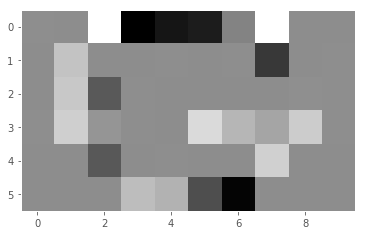

In [16]:
out_opt = sim.pulse2percept(xopt, 20, layers=layers)
out_opt.shape

NameError: name 'out_opt' is not defined

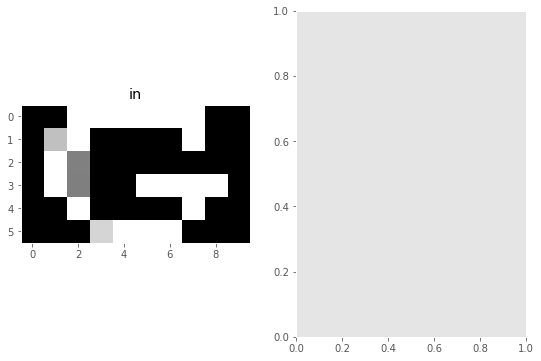

In [105]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_small, cmap='gray')
plt.title('in')
plt.subplot(132)
plt.imshow(out_opt, cmap='gray')
plt.title('struct sim: %.3f' % skim.compare_ssim(out_opt / out_opt.max(), target / target.max(), dynamic_range=1.0))
plt.subplot(133)
plt.imshow(target, cmap='gray')
plt.title('target')

In [145]:
out_small = sim.pulse2percept(img_small, 20, layers=['GCL'])

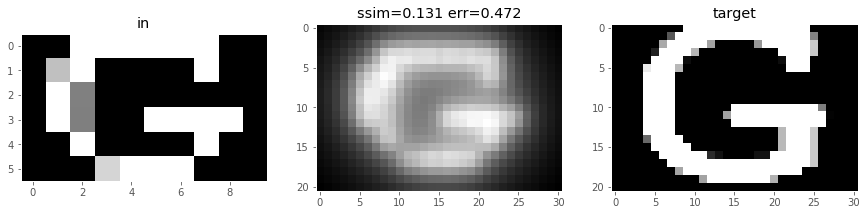

In [155]:
plt.figure(figsize=(15, 6))
plot_results(img_small, out_small, target)

In [156]:
opt_gcl = pickle.load(open('../../scripts/optimize-G-gcl.dat', 'rb'))
opt_gcl = np.maximum(0, opt_gcl)
opt_gcl.min(), opt_gcl.max()

(0.0, 2.0913373654831213)

In [157]:
out_gcl = sim.pulse2percept(opt_gcl, 20, layers=['GCL'])
out_gcl.shape

(21, 31)

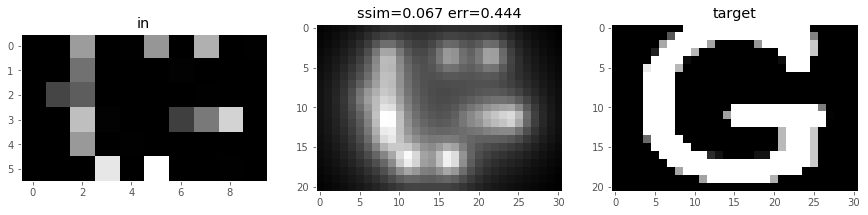

In [158]:
plt.figure(figsize=(15, 6))
plot_results(opt_gcl, out_gcl, target)

In [159]:
opt_ofl = pickle.load(open('../../scripts/optimize-G-ofl.dat', 'rb'))
opt_ofl = np.maximum(0, opt_ofl)
opt_ofl.min(), opt_ofl.max()

(0.0, 2.0913373654831213)

In [160]:
out_ofl = sim.pulse2percept(opt_ofl, 20, layers=['GCL', 'OFL'])
out_ofl.shape

(21, 31)

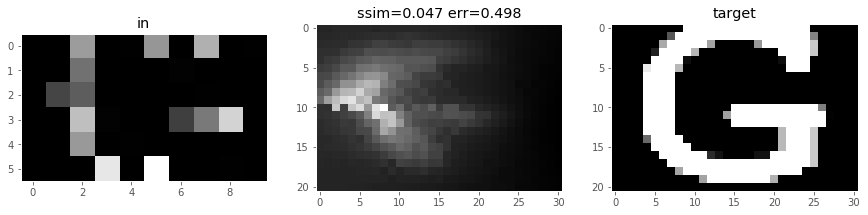

In [161]:
plt.figure(figsize=(15, 6))
plot_results(opt_ofl, out_ofl, target, lmb=0.001)

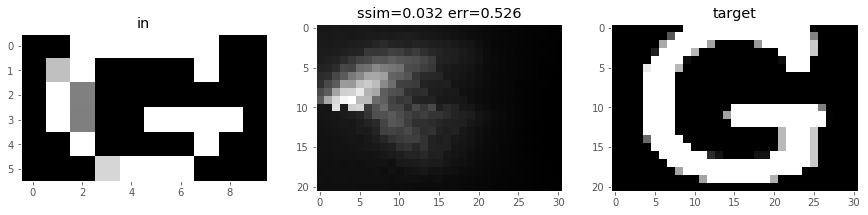

In [162]:
out_small = sim.pulse2percept(img_small, 20, layers=['GCL', 'OFL'])
plt.figure(figsize=(15, 6))
plot_results(img_small, out_small, target, lmb=0.001)